<a href="https://colab.research.google.com/github/KostasFotakis/Semantic-Segmentation-w-UNet-architecture-on-Covid-19-infected-Chest-Xrays/blob/main/UNet_model_load_and_predicted_with_saved_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import random
import re
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet(input_size=(256,256,1))

In [ ]:
model.load_weights("/content/drive/MyDrive/cxr_reg_weights.best.hdf5")

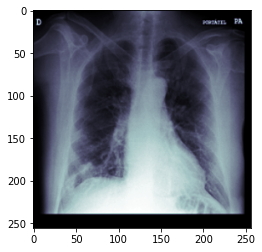

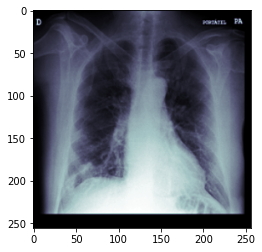

In [ ]:
img_path = ""



X_shape = 256

x_im = cv2.resize(cv2.imread(img_path),(X_shape,X_shape))[:,:,0]

x_im.reshape(1, x_im.shape[0], x_im.shape[1], 1).shape

#x_im.shape



op = model.predict((x_im.reshape(1, 256, 256, 1)-127.0)/127.0)



#op.shape

plt.imshow(x_im,cmap="bone", label="Input Image")
plt.show()

plt.imshow(x_im, cmap="bone", label="Output Image")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

plt.subplot(1,4,1)
x_im = cv2.resize(cv2.imread(img_path),(X_shape,X_shape))[:,:,0]

x_im.reshape(1, x_im.shape[0], x_im.shape[1], 1).shape
plt.imshow(x_im, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
plt.imshow(op.reshape(256, 256), alpha=1.0, cmap='Greys_r')
plt.axis('off')
plt.title('Predicted X-Ray Mask')

mask_l = np.zeros(op.shape, dtype="uint8")
plt.subplot(1,4,3)
mask_l = cv2.bitwise_and(x_im, x_im, mask=op.reshape(256,256).astype(np.uint8))
plt.imshow(mask_l , cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')


from PIL import Image, ImageFilter
im = Image.fromarray(mask_l)
im.save("your_file.png")



In [ ]:
COVID_FOR_SEGM_PATH = "/content/drive/MyDrive/NORAML CHEST XRAYS FOR SEGMENTATION"
cov_segm_images_list = os.listdir(COVID_FOR_SEGM_PATH)

print(cov_segm_images_list[0])

mask = [fName.split(".png")[0] for fName in cov_segm_images_list]

check = [i for i in mask if "_0" in i]

len(check)

CHNCXR_0002_0.png


326

100%|██████████| 326/326 [09:31<00:00,  1.75s/it]


Text(0.5, 1.0, 'Predicted Lung Segmentation')

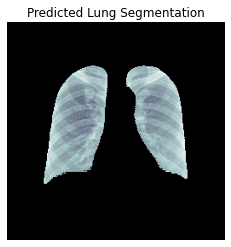

In [ ]:
cov_files_number = check

file_path = "/content/drive/MyDrive/NORAML CHEST XRAYS FOR SEGMENTATION/"

destination_path = "/content/drive/MyDrive/COVID_SEGMENTED_LUNG_XRAYS"
from PIL import Image, ImageFilter

def load_data_for_segmentation(X_shape):
    
    
          for i,mask_name in enumerate(tqdm(cov_segm_images_list)):

                  img_path =  file_path + str(mask_name)

                  #print(img_path)

                  x_im = cv2.resize(cv2.imread(img_path),(X_shape,X_shape))[:,:,0]

                  x_im.reshape(1, x_im.shape[0], x_im.shape[1], 1).shape

                  op = model.predict((x_im.reshape(1, 256, 256, 1)-127.0)/127.0)

                  mask_l = np.zeros(op.shape, dtype="uint8")

                  mask_l = cv2.bitwise_and(x_im, x_im, mask=op.reshape(256,256).astype(np.uint8))

                  im = Image.fromarray(mask_l)
                  #im = mask_l




                  im.save(f"/content/drive/MyDrive/NORMAL SEGMENTED LUNG XRAYS/{str(mask_name)}")


                  #cv2.imwrite(f'/content/drive/MyDrive/COVID SEGMENTED LUNG XRAYS_{i}.png',im.astype(np.uint8))

          return im

plt.imshow(load_data_for_segmentation(256) , cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')